In [1]:
# 目的建立autoencoder for MINST 训练集 ，并实现可视化
import torch.nn as nn
import torch
import numpy as np
from torch.utils import data
from torch.autograd import Variable
import torchvision
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [156]:
# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
HIDDEN_DIMENSION = 128
LR = 0.005         # learning rate
DOWNLOAD_MNIST = True
N_TEST_IMG = 5

In [140]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [141]:
# 下载数据
train_data = torchvision.datasets.MNIST(
    root= './mnist/',
    train= True,
    download= True,
    transform = torchvision.transforms.ToTensor()
)

print(train_data.data)
print(train_data.targets)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [142]:
train_data.data.size()

torch.Size([60000, 28, 28])

In [143]:
# 构建dataloader
train_loader = data.DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    shuffle= True
)
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [181]:
#建网络
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        # 建立一个Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28,128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64,12),
            nn.Tanh(),
            nn.Linear(12,3)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )
        
    def forward(self,image):
        ret_encoder = self.encoder(image)
        ret_decoder = self.decoder(ret_encoder)
        
        return ret_encoder, ret_decoder

In [182]:
module = AutoEncoder().to(device)

In [183]:
#建优化器
optimizer = torch.optim.Adam(module.parameters(), lr=LR)

In [184]:
#定义loss
loss_fn = nn.MSELoss()

In [233]:
#定义学习方式

import time

zero_clock = time.time()

#定义检查显示图像
#view_data = train_data.data[:N_TEST_IMG].detach().clone().cuda()
view_data = Variable(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)).cuda()
print(f"view_data shape {view_data.size()}")

# 一个epoch的学习
def train_net(loader: torch.utils.data.dataloader.DataLoader,epoch = -1):
    for step,(x_b,y_t) in enumerate(loader):
        # Input of encoder
        x_e = torch.tensor(x_b, device = device, requires_grad = True)
        x_e = x_e.view(-1,28*28)
        
        
        # Lable of decoder
        y_d = x_e.detach().clone().cuda()
        #print(x_e.device,y_d.device)
        
        #print(x_e.shape)

        encode,decode = module(x_e)
        #print(encode.device,decode.device)
        
        loss = loss_fn(decode,y_d)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 500 == 0:
            time_tick = time.time() - zero_clock
            print(f"In the {epoch}th epoch, step {step} , run time is {time_tick}")
            print(f"Until now the loss of decoder is {loss}")
            # Display 1. distribution of encoded sambles; 2. Decoded image
            
            
            # Decoded image
            print("view data size:",view_data.size())
            #_, decoded_image = autoencoder(view_data.view(-1,28*28).type(torch.FloatTensor)/255.)
            _ , decoded_image = module(view_data)
            print(decoded_image.device, view_data.device)
            print("decode success!!")
            
            # Canvas for image Mosaic
            fig , ax = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
            
            
            # Draw decoded images in the first line
            for i in range(N_TEST_IMG):
                ax[0][i].clear()
                ax[0][i].imshow(decoded_image.detach().view(-1,28,28).cpu()[i].numpy(),cmap='gray')
                ax[0][i].set_title(f"The {i}th decoded image")
                ax[0][i].set_xticks(())
                ax[0][i].set_yticks(())
                
            for i in range(N_TEST_IMG):
                ax[1][i].clear()
                ax[1][i].imshow(view_data.view(-1,28,28).cpu()[i].numpy(),cmap='gray')
                ax[1][i].set_title(f"The {i}th real image")
                ax[1][i].set_xticks(())
                ax[1][i].set_yticks(())
            plt.show()
            plt.pause(0.05)

view_data shape torch.Size([5, 784])


C:\Users\ZOEZHA~1\AppData\Local\Temp/ipykernel_25036/72604429.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_e = torch.tensor(x_b, device = device, requires_grad = True)


In the 0th epoch, step 0 , run time is 69.42031264305115
Until now the loss of decoder is 0.03704313188791275
view data size: torch.Size([5, 784])
cuda:0 cuda:0
decode success!!
In the 0th epoch, step 500 , run time is 75.7295355796814
Until now the loss of decoder is 0.033994585275650024
view data size: torch.Size([5, 784])
cuda:0 cuda:0
decode success!!
In the 1th epoch, step 0 , run time is 80.7552101612091
Until now the loss of decoder is 0.03551634028553963
view data size: torch.Size([5, 784])
cuda:0 cuda:0
decode success!!
In the 1th epoch, step 500 , run time is 86.41611313819885
Until now the loss of decoder is 0.04097934439778328
view data size: torch.Size([5, 784])
cuda:0 cuda:0
decode success!!
In the 2th epoch, step 0 , run time is 91.3875322341919
Until now the loss of decoder is 0.036691151559352875
view data size: torch.Size([5, 784])
cuda:0 cuda:0
decode success!!
In the 2th epoch, step 500 , run time is 97.19536542892456
Until now the loss of decoder is 0.0345040373504

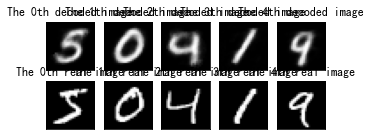

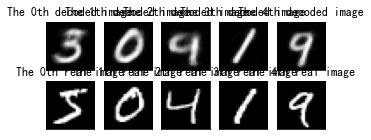

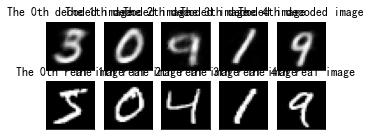

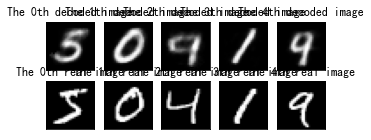

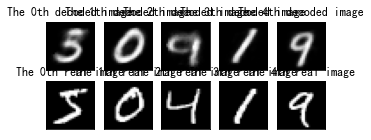

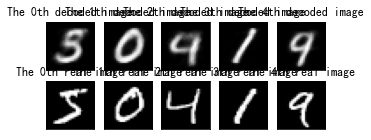

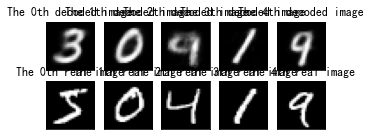

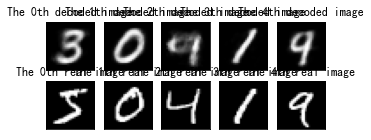

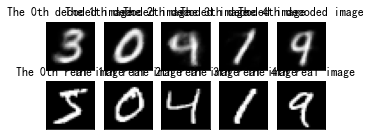

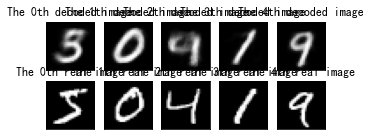

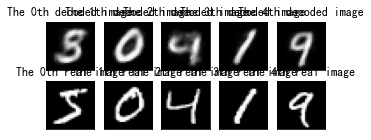

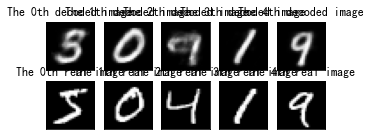

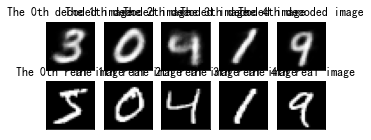

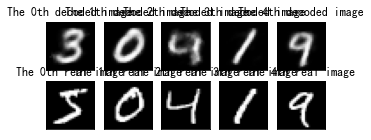

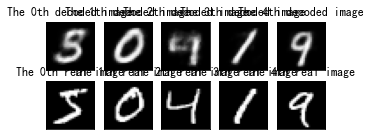

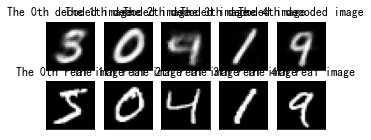

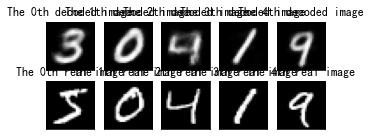

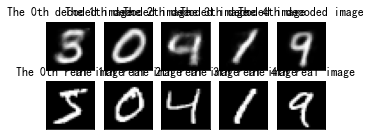

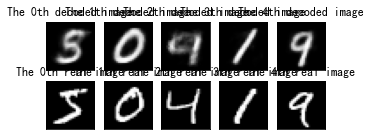

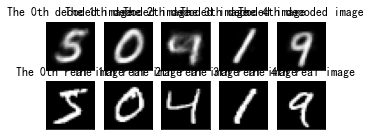

In [235]:
for epoch in range(EPOCH):
    train_net(train_loader,epoch)